In [1]:
from autocvd import autocvd
autocvd(num_gpus=5, )

[0, 1, 3, 5, 6]

In [2]:
import os
os.chdir('/export/home/bguenes/COMPASS/')
from src.compass import ScoreBasedInferenceModel as SBIm
from src.compass import ModelTransfuser as MTf
os.chdir('/export/home/bguenes/COMPASS/tutorials')

In [3]:
# from compass import ScoreBasedInferenceModel as SBIm
# from compass import ModelTransfuser as MTf

In [4]:
import torch

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# --- 1. General ODE Solver (using simple Euler method) ---
def solve_ode(model_func, initial_state, params, t_max, dt):
    """
    Solves a system of ODEs using the Euler method.

    Args:
        model_func (function): The function defining the ODEs (e.g., lotka_volterra).
        initial_state (torch.Tensor): The starting values [N, P].
        params (dict): A dictionary of parameters for the model.
        t_max (int): The maximum simulation time.
        dt (float): The time step.

    Returns:
        (torch.Tensor, torch.Tensor): Tensors for time points and population history.
    """
    # Setup time steps and history arrays
    time_steps = torch.arange(0, t_max, dt)
    history = torch.zeros(initial_state.shape[0], len(time_steps), 2)
    history[:, 0, :] = initial_state
    
    # Current state starts at the initial state
    current_state = initial_state.clone()

    # Euler integration loop
    for i in range(1, len(time_steps)):
        # Get the derivatives from the model function
        derivatives = model_func(current_state, params)
        # Update the state using the Euler step
        current_state += derivatives * dt
        # Ensure populations don't go below zero
        current_state = torch.max(current_state, torch.tensor([0.0, 0.0]))
        history[:, i, :] = current_state
        
    return time_steps, history

In [6]:
# --- 2. The Four Competing Model Functions ---
# Each model uses exactly four parameters: {alpha, beta, gamma, delta}

def lotka_volterra(state, params):
    """Model 1: Classic Lotka-Volterra dynamics."""
    N, P = state.T
    alpha, beta, gamma, delta = params.T

    dN_dt = alpha * N - beta * N * P
    dP_dt = delta * N * P - gamma * P
    return torch.stack([dN_dt, dP_dt]).T

def logistic_prey(state, params):
    """Model 2: Prey with logistic growth."""
    
    N, P = state.T
    alpha, beta, gamma, delta = params.T
    delta_lp = delta * 1000  # Prey carrying capacity (logistic growth)
    cn_rate = 0.5  # Fixed conversion efficiency

    dN_dt = alpha * N * (1 - N / delta_lp) - beta * N * P
    dP_dt = cn_rate * beta * N * P - gamma * P
    return torch.stack([dN_dt, dP_dt]).T

def satiated_predator(state, params):
    """Model 3: Predator with satiation (Holling Type II)."""
    N, P = state.T
    alpha, beta, gamma, delta = params.T
    cn_rate = 0.5 # Fixed conversion efficiency

    consumption = (beta * N) / (1 + beta * delta * N)
    dN_dt = alpha * N - consumption * P
    dP_dt = cn_rate * consumption * P - gamma * P
    return torch.stack([dN_dt, dP_dt]).T

def rosenzweig_macarthur(state, params):
    """Model 4: Both logistic prey and satiated predator."""
    N, P = state.T
    alpha, beta, gamma, delta = params.T
    delta_rm = delta * 1000  # 
    cn_rate = 0.5 # Fixed conversion efficiency
    h_rate = 0.1 # Fixed handling time

    consumption = (beta * N) / (1 + beta * h_rate * N)
    dN_dt = alpha * N * (1 - N / delta_rm) - consumption * P
    dP_dt = cn_rate * consumption * P - gamma * P
    return torch.stack([dN_dt, dP_dt]).T

In [7]:
# --- 3. Simulation Setup ---
# Initial conditions [N0, P0]
initial_state = torch.tensor([[30.0, 1.0]])

# Simulation time
t_max = 20
dt = 0.01

# List of models to run
models = {
    "Lotka-Volterra": lotka_volterra,
    "Logistic Prey": logistic_prey,
    "Satiated Predator": satiated_predator,
    "Rosenzweig-MacArthur": rosenzweig_macarthur
}

## Initialize COMPASS

In [8]:
mtf = MTf(path="data/predator_prey")

In [9]:
# Load the pretrained models
for model_name, _ in models.items():
    try:
        sbim = SBIm.load(f"data/predator_prey/{model_name}_checkpoint.pt", device="cuda")
    except:
        sbim = SBIm.load(f"data/predator_prey/{model_name}.pt", device="cuda")
    mtf.add_model(model_name, sbim)

Model Lotka-Volterra added to transfuser.
Model Logistic Prey added to transfuser.
Model Satiated Predator added to transfuser.
Model Rosenzweig-MacArthur added to transfuser.


# Tests

In [10]:
test_params = torch.tensor([[-0.1, -3.0, -0.1, -3.0]])

In [11]:
#test_params = prior.sample(1)
model_func = models["Lotka-Volterra"]
time, history = solve_ode(model_func, torch.tensor([[30.0,1.0]]), torch.exp(test_params), 20, 0.01)
test_data = history[:, time % 1 == 0].flatten(1)/100

In [21]:
mtf.compare(x=test_data, device="cuda", timesteps=50, method="dpm", order=2)

Probabilities of the models after 1 observations:
Lotka-Volterra      : 100.00 %
Logistic Prey       :   0.00 %
Satiated Predator   :   0.00 %
Rosenzweig-MacArthur:   0.00 %

Model Lotka-Volterra fits the data best with a relative support of 100.0% among the considered models.


In [22]:
mtf.stats["Lotka-Volterra"]["MAP"], mtf.stats["Logistic Prey"]["MAP"], mtf.stats["Satiated Predator"]["MAP"], mtf.stats["Rosenzweig-MacArthur"]["MAP"]

(array([[[-0.08532856, -2.97079778, -0.09869578, -3.00799084],
         [ 0.04779522,  0.06070776,  0.04807578,  0.05300643]]]),
 array([[[ 0.08193482, -2.35288978, -0.66835439, -1.72237313],
         [ 0.14635274,  0.10117135,  0.11032575,  0.22409043]]]),
 array([[[ 0.07531656, -2.43515587, -0.19763891, -3.97457266],
         [ 0.05922826,  0.06238122,  0.06806848,  0.15605265]]]),
 array([[[ 0.67386723, -1.63929629, -0.27484602, -2.14363718],
         [ 0.13151547,  0.12963855,  0.10380033,  0.13906674]]]))

In [23]:
mtf.stats["Lotka-Volterra"]["AIC"], mtf.stats["Logistic Prey"]["AIC"], mtf.stats["Satiated Predator"]["AIC"], mtf.stats["Rosenzweig-MacArthur"]["AIC"]

(tensor(21.1007), tensor(-7.7856), tensor(-147.5538), tensor(2.9365))

In [24]:
def plot_results_test(names):
    initial_state = torch.tensor([[30.0,1.0]])

    # Simulation time
    t_max = 20
    dt = 0.01

    fig, axs = plt.subplots(2,1, sharex=True, figsize=(10,5), constrained_layout=True, dpi=500)

    time = torch.arange(0,20)

    #sns.lineplot(x=time, y=test_data[0,::2]*100, color='blue', alpha=0.5)
    #sns.lineplot(x=time, y=test_data[0,1::2]*100, color='orange', alpha=0.5)

    colours = ['blue', 'orange', 'green', 'red']
    for i, model_name in enumerate(names):
        params = torch.exp(torch.tensor(mtf.stats[model_name]["MAP"][0,0]))
        time_best, history_best = solve_ode(models[model_name], initial_state, params, t_max, dt)
        sns.lineplot(x=time_best, y=history_best[0, :, 0], color=colours[i], label=model_name, ax=axs[0])
        sns.lineplot(x=time_best, y=history_best[0, :, 1], color=colours[i], label=model_name, ax=axs[1])

    # sns.scatterplot(x=time, y=test_data[0,::2]*100, label='Measurement', color='k', ax=axs[0])
    # sns.scatterplot(x=time, y=test_data[0,1::2]*100, label='Measurement', color='k', ax=axs[1])

    axs[0].scatter(x=time, y=test_data[0,::2]*100,
                     color='k', label='Measurement', s=10, zorder=10)
    axs[1].scatter(x=time, y=test_data[0,1::2]*100,
                     color='k', label='Measurement', s=10, zorder=10)

    axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=len(names)+1, frameon=False)
    plt.xlabel('Time', fontsize=12)
    plt.xlim(0,20)
    axs[0].set_ylabel('Prey Population')
    axs[1].set_ylabel('Predator Population')
    plt.tight_layout()
    axs[1].legend().remove()
    for ax in axs:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    plt.show()

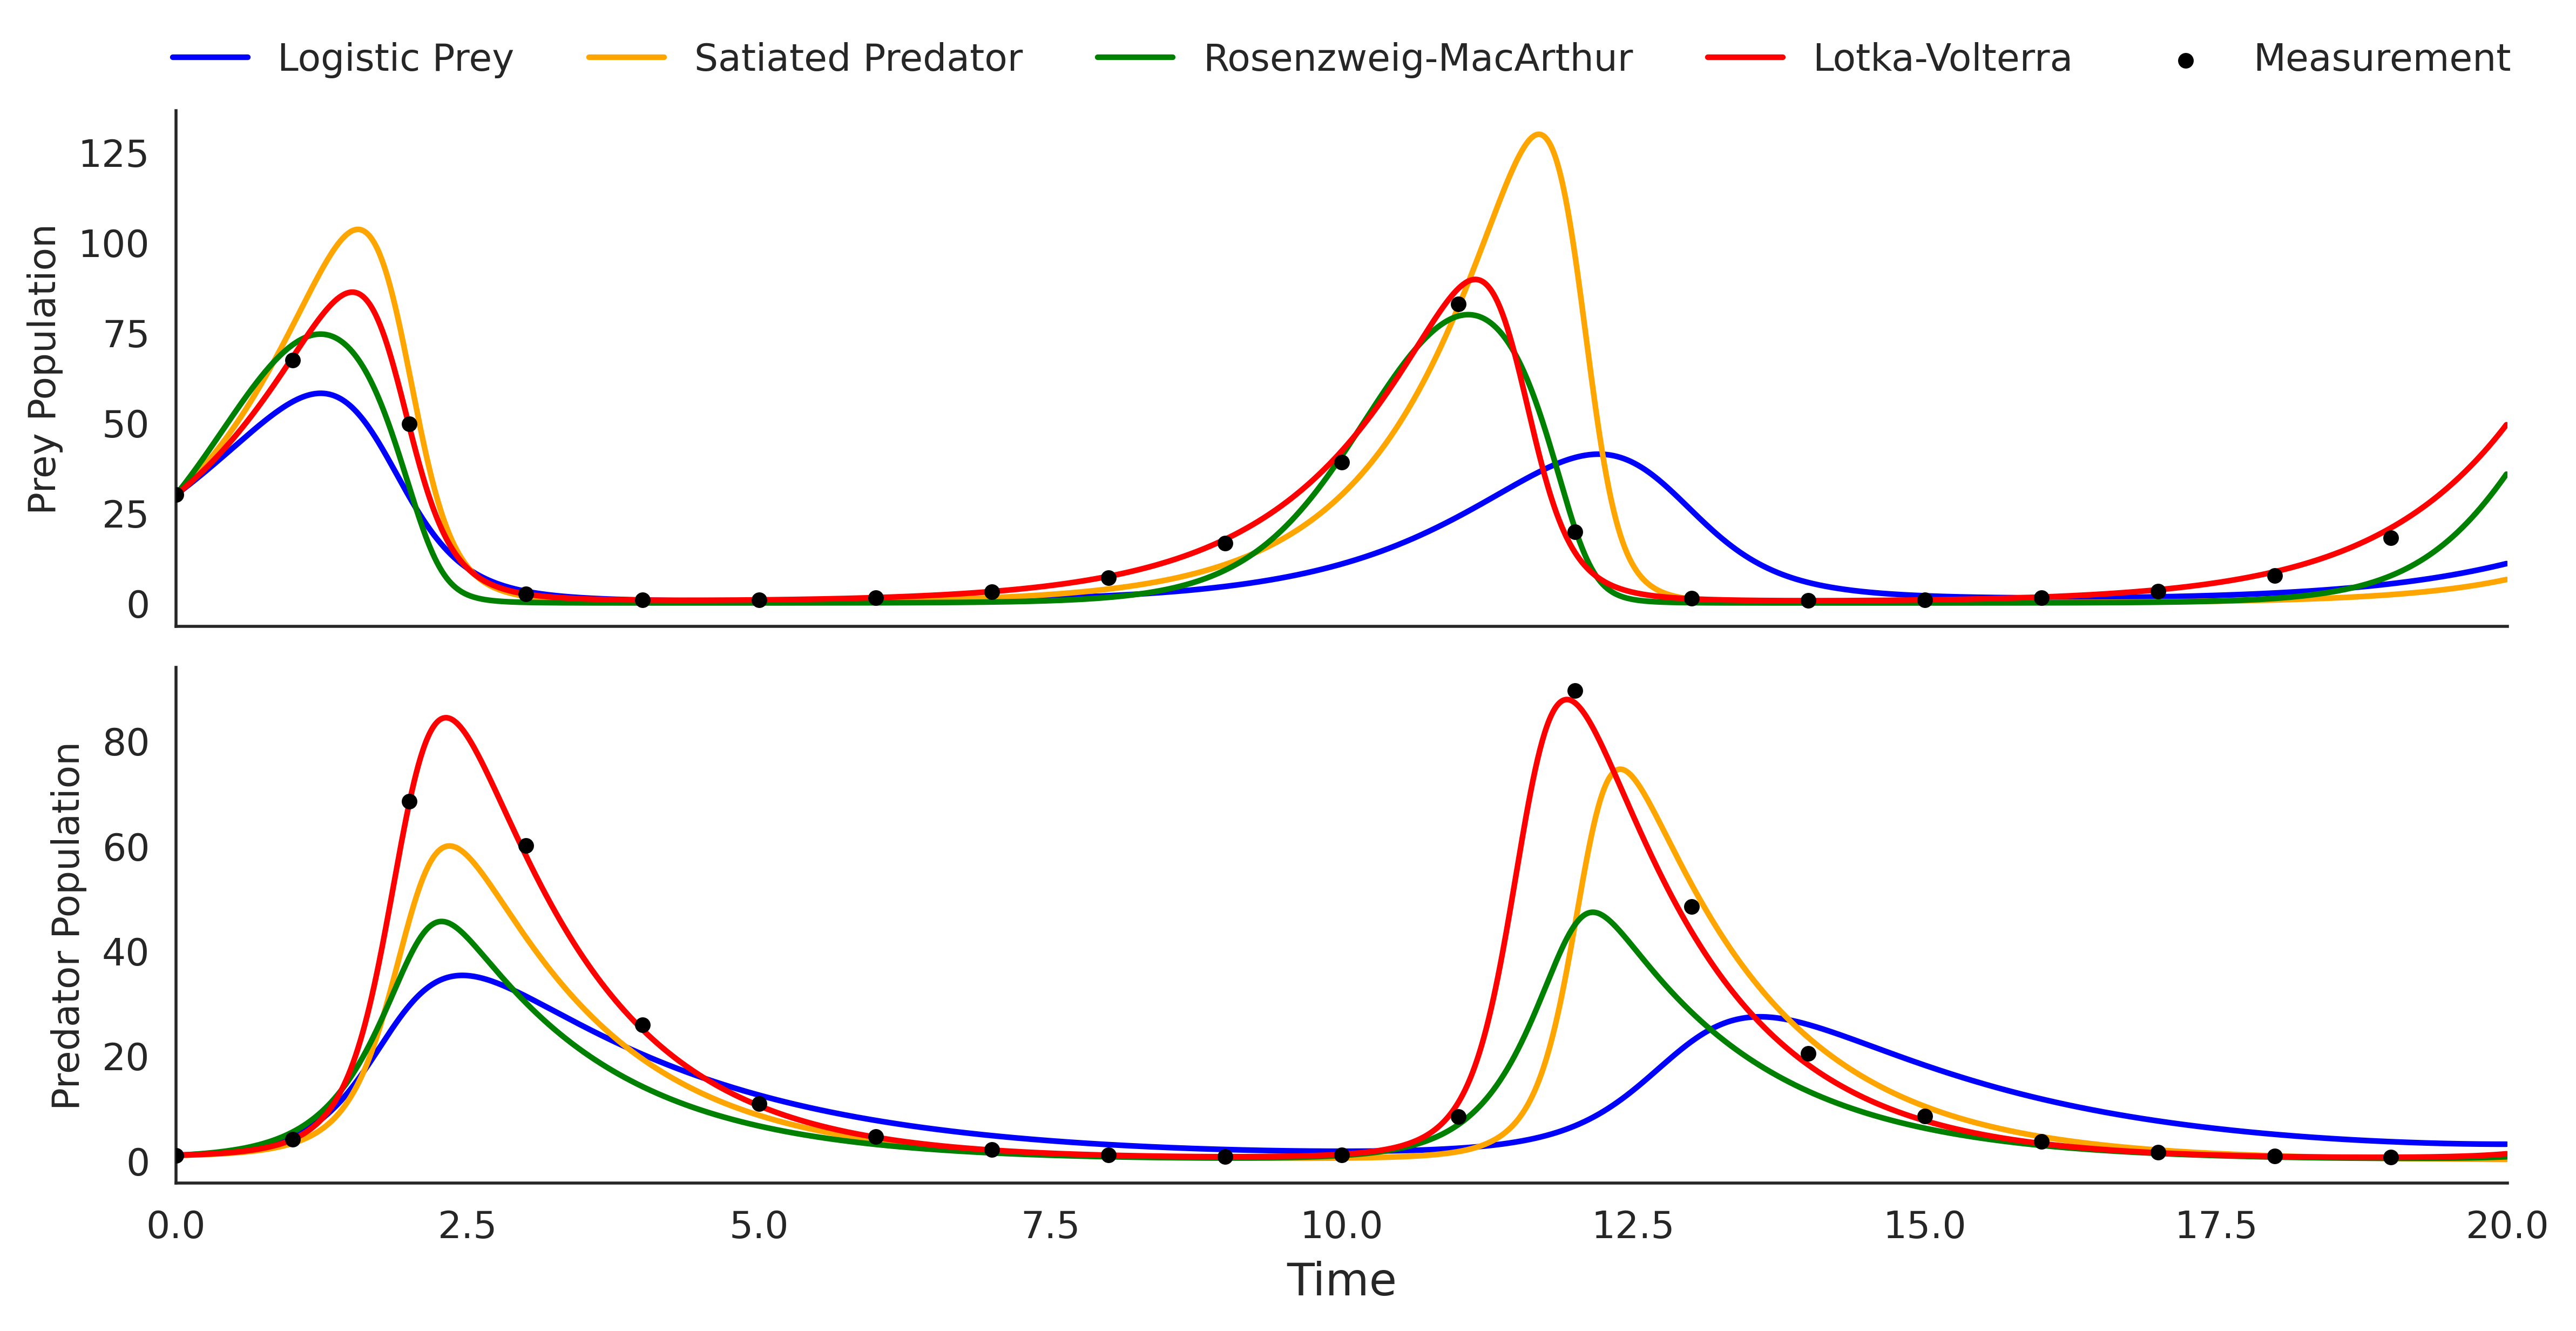

In [25]:
names = ["Logistic Prey", "Satiated Predator", "Rosenzweig-MacArthur", "Lotka-Volterra"]
plot_results_test(names)

In [28]:
def plot_res(model_names):
    samples = {}
    
    for model_name in model_names:
        try:
            sbim = SBIm.load(f"data/predator_prey/{model_name}_checkpoint.pt", device="cuda")
        except:
            sbim = SBIm.load(f"data/predator_prey/{model_name}.pt", device="cuda")

        theta_hat = torch.tensor(mtf.stats[model_name]["MAP"][0,0]).float()
        err = torch.tensor(mtf.stats[model_name]["MAP"][0,1]).float()

        samples[model_name] = sbim.sample(theta=theta_hat, err=err, device="cuda", timesteps=50, method="dpm", order=2)

    # plot histograms of samples and true values
    fig, ax = plt.subplots(2, 20, figsize=(14, 2), sharey=True, dpi=500)
    sns.set_style("white")
    fig.text(0.1, 0.5, 'Population Densities', va='center', rotation='vertical', fontsize=12)

    colours = ['blue', 'orange', 'green', 'red']

    for i in range(samples[model_name].shape[2]):
        row, col = i % 2, i // 2
        for j, model_name in enumerate(model_names):
            sns.kdeplot(samples[model_name][0, :, i].cpu().numpy()*100, fill=True, alpha=0.3, ax=ax[row, col], color=colours[j])

        ax[row, col].axvline(x=test_data[0, i]*100, color='k', linestyle=':', label='True Value')
        if row == 0:
            ax[row, col].set_title(rf'$T_{{{i/2.0:.0f}}}$')
            if i == 0:
                ax[row, col].set_ylabel("N", labelpad=-8)
        if row == 1 and col == 0:   
            ax[row, col].set_ylabel("P", labelpad=-8)
        ax[row, col].set_xticklabels([])
        ax[row, col].set_yticklabels([])
        ax[row, col].tick_params(left=False, bottom=False)

        for spine in ax[row, col].spines.values():
            spine.set_visible(False)

    fig.legend(model_names + ['True Value'], loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(model_names)+1, frameon=False)
    fig.subplots_adjust(wspace=0, hspace=0.1)
    plt.show()

100%|████████████████████████████████████████████| 1/1 [00:04<00:00,  4.74s/it]


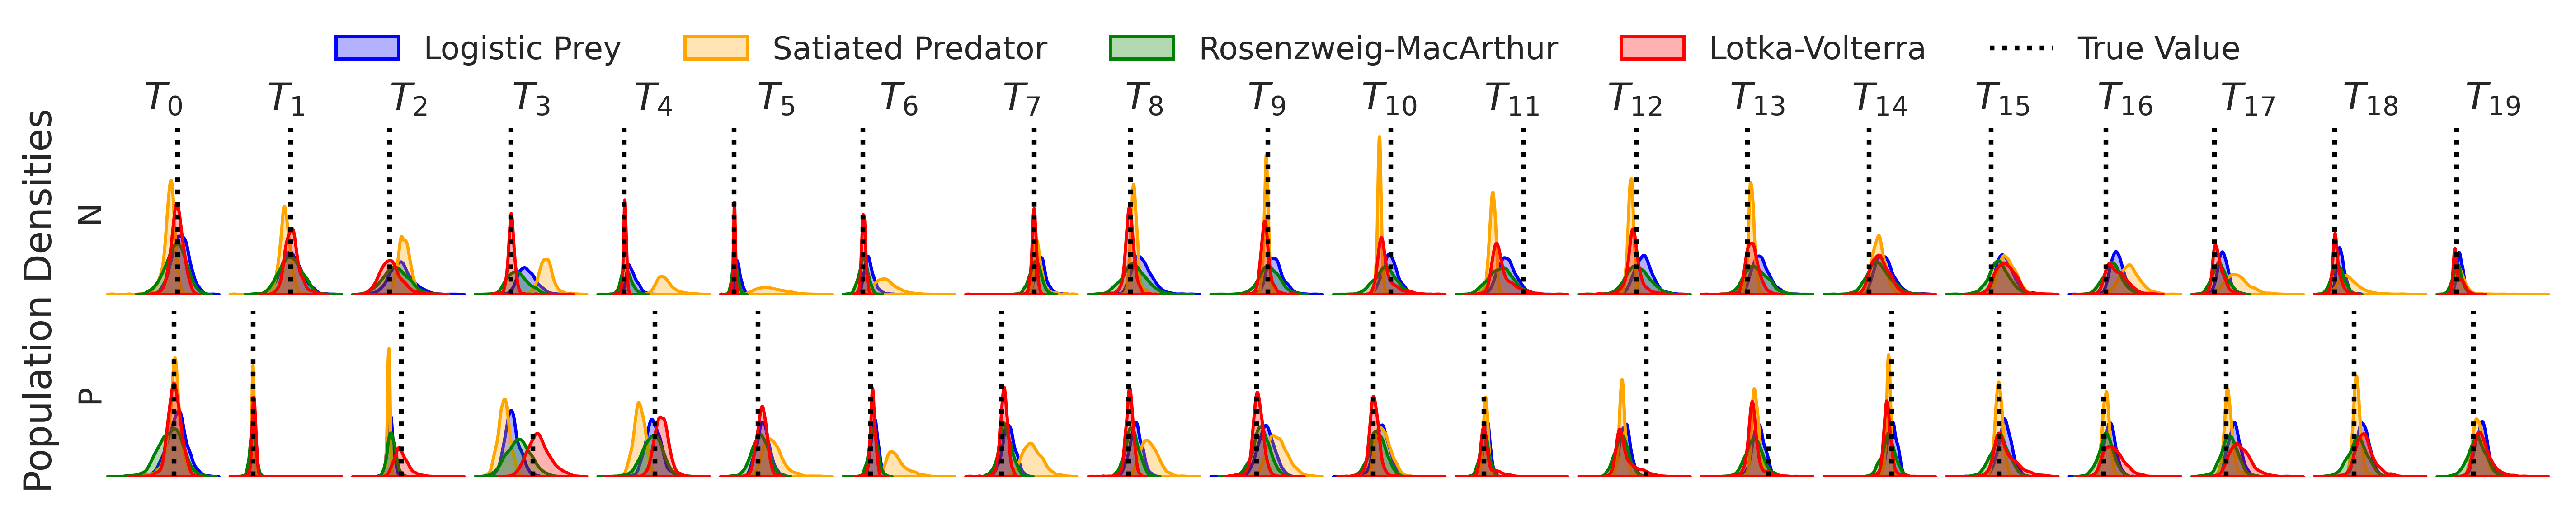

In [29]:
names = ["Logistic Prey", "Satiated Predator", "Rosenzweig-MacArthur", "Lotka-Volterra"]
plot_res(names)